In [2]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


C:\Users\user\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


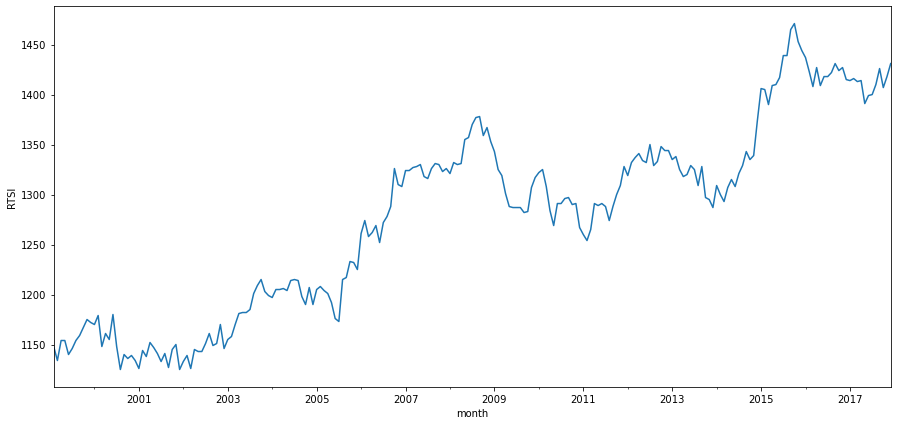

In [4]:
df6 = pd.read_csv('C:/Users/user/Desktop/event_data_train/VASYA6.csv',',', index_col=['month'], parse_dates=['month'], dayfirst=True)
#C:\Users\user\Downloads
plt.figure(figsize(15,7))
df6.id.plot()
plt.ylabel('RTSI')
pylab.show()

Критерий Дики-Фуллера: p=0.803904


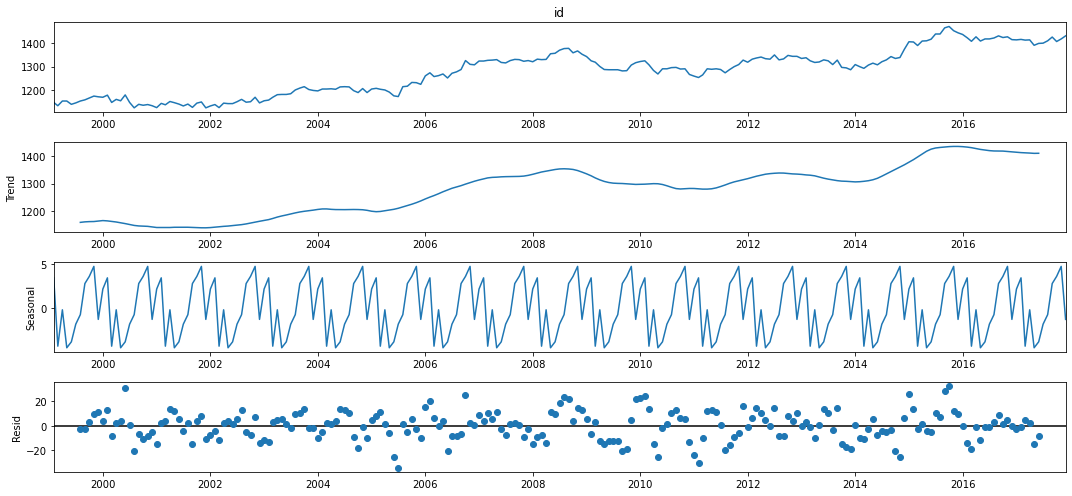

In [5]:
sm.tsa.seasonal_decompose(df6.id,period=12).plot()
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df6.id)[1])

Оптимальный параметр преобразования Бокса-Кокса: 0.919262
Критерий Дики-Фуллера: p=0.802090


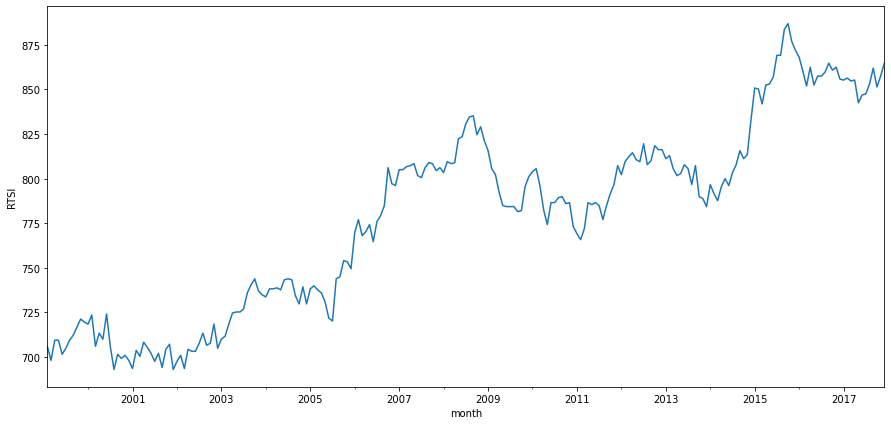

In [6]:
df6['sales_box'], lmbda = stats.boxcox(pd.to_numeric(df6.id))
plt.figure(figsize(15,7))
df6.sales_box.plot()
plt.ylabel(u'RTSI')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df6.sales_box)[1])

Критерий Дики-Фуллера: p=0.023406


<Figure size 1080x720 with 0 Axes>

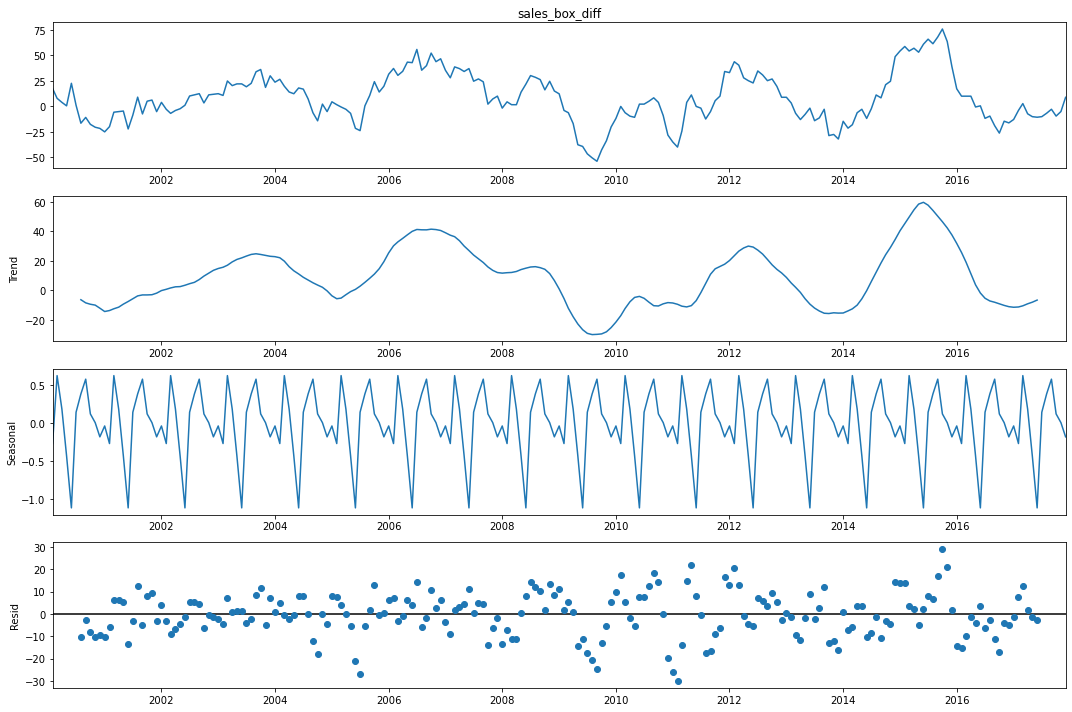

In [7]:
df6['sales_box_diff'] = df6.sales_box - df6.sales_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df6.sales_box_diff[12:],period=12).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df6.sales_box_diff[12:])[1])

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

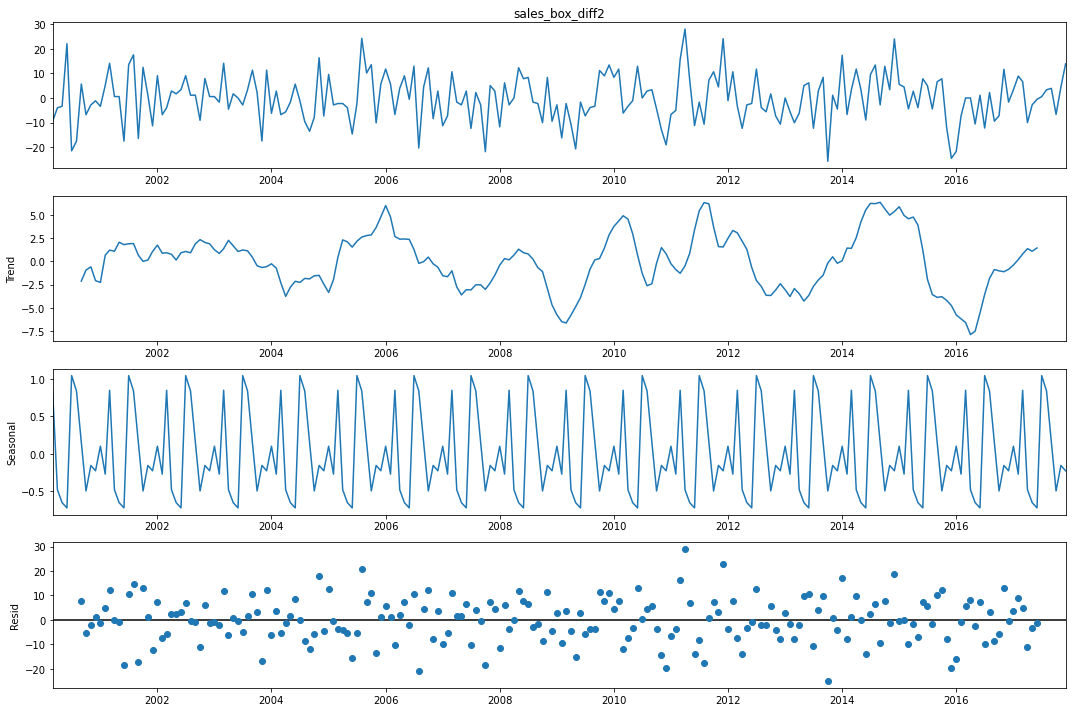

In [8]:
df6['sales_box_diff2'] = df6.sales_box_diff - df6.sales_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df6.sales_box_diff2[13:],period=12).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df6.sales_box_diff2[13:])[1])

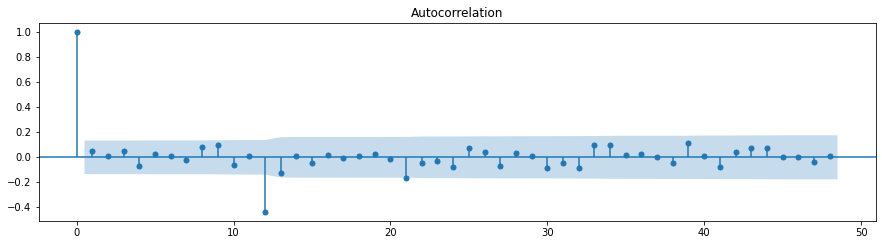

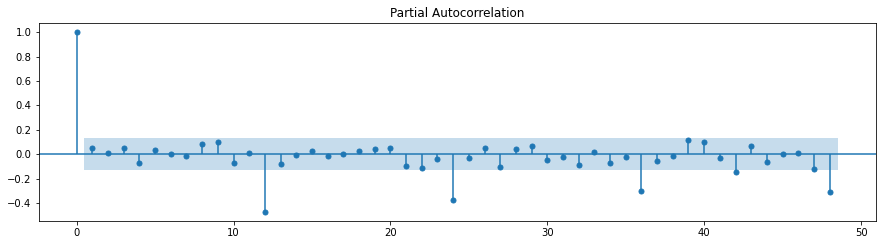

In [9]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df6.sales_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df6.sales_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

In [10]:
ps = range(0, 5)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [11]:
from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

In [12]:

%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df6.sales_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 41.9 s


In [13]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
1   (0, 0, 0, 1)  1483.254684
33  (2, 2, 0, 1)  1484.124492
3   (0, 0, 1, 1)  1484.769548
5   (0, 1, 0, 1)  1484.848100
13  (1, 0, 0, 1)  1484.866289


C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                            sales_box   No. Observations:                  227
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -739.627
Date:                              Mon, 05 Apr 2021   AIC                           1483.255
Time:                                      13:34:42   BIC                           1489.987
Sample:                                  02-01-1999   HQIC                          1485.975
                                       - 12-01-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.8443      0.055    -15.265      0.000      -0.953      -0.736
sigma2        54.85

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Критерий Стьюдента: p=0.961004
Критерий Дики-Фуллера: p=0.000000


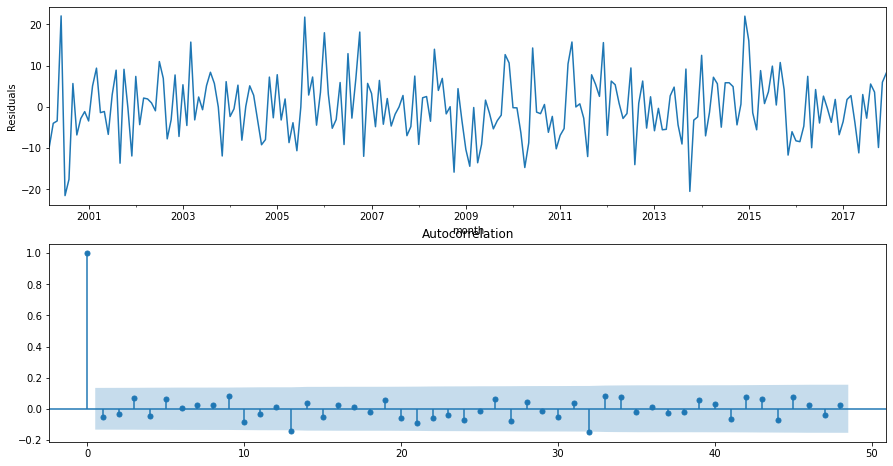

In [15]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


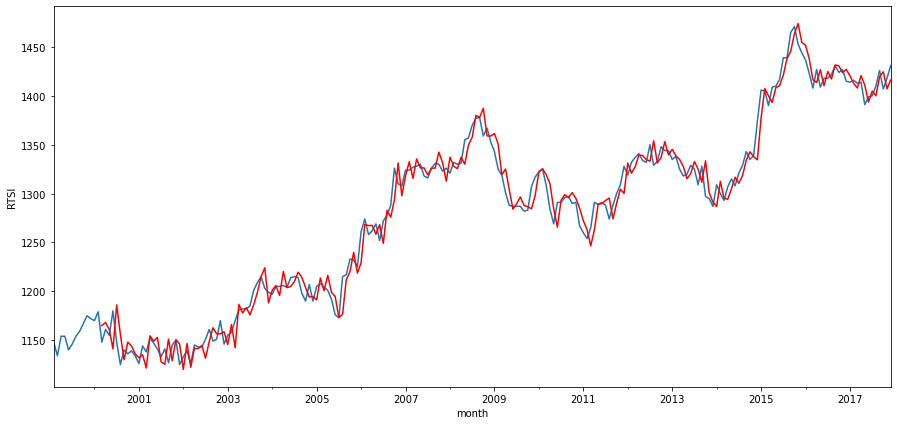

In [16]:
df6['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
df6.id.plot()
df6.model[13:].plot(color='r')
plt.ylabel('RTSI')
pylab.show()


In [17]:
from sklearn.model_selection import TimeSeriesSplit
#Specify fold and perform splitting
# Указать сгиб и выполнить разделение
tscv = TimeSeriesSplit(n_splits=3)
tscv.split(df6)
#Find out no of observations in train and test sets
# Узнать количество наблюдений в тренировочных и тестовых наборах
i=0
for train, test in tscv.split(df6):
    
    print ("No of observations under train%s=%s" % (i, len(train)))
    print ("No of observations under test%s=%s" % (i, len(test)))

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


No of observations under train0=59
No of observations under test0=56
No of observations under train0=115
No of observations under test0=56
No of observations under train0=171
No of observations under test0=56


<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [18]:
train1, test1 = df6.iloc[:59, 0], df6.iloc[59:115, 0]
train2, test2 = df6.iloc[:115, 0], df6.iloc[115:171, 0]
train3, test3 = df6.iloc[:171, 0], df6.iloc[171:227, 0]

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
#Fit a model
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt

#First fold RMSE
model1 = ExponentialSmoothing(train1, seasonal='mul', seasonal_periods=12).fit()
pred1 = model1.predict(start=test1.index[0], end=test1.index[-1])
RMSE1=round(sqrt(mean_squared_error(test1, pred1)),2)

#Second fold RMSE
model2 = ExponentialSmoothing(train2, seasonal='mul', seasonal_periods=12).fit()
pred2 = model2.predict(start=test2.index[0], end=test2.index[-1])
RMSE2=round(sqrt(mean_squared_error(test2, pred2)),2)

#Third fold RMSE
model3 = ExponentialSmoothing(train3, seasonal='mul', seasonal_periods=12).fit()
pred3 = model3.predict(start=test3.index[0], end=test3.index[-1])
RMSE3=round(sqrt(mean_squared_error(test3, pred3)),2)

print ("RMSE1:", RMSE1)
print ("RMSE2:", RMSE2)
print ("RMSE3:", RMSE3)

Overall_RMSE=round((RMSE1+RMSE2+RMSE3)/3,2)
print ("Overall RMSE:", Overall_RMSE) 

C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency infor

RMSE1: 87.67
RMSE2: 70.47
RMSE3: 84.47
Overall RMSE: 80.87


C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


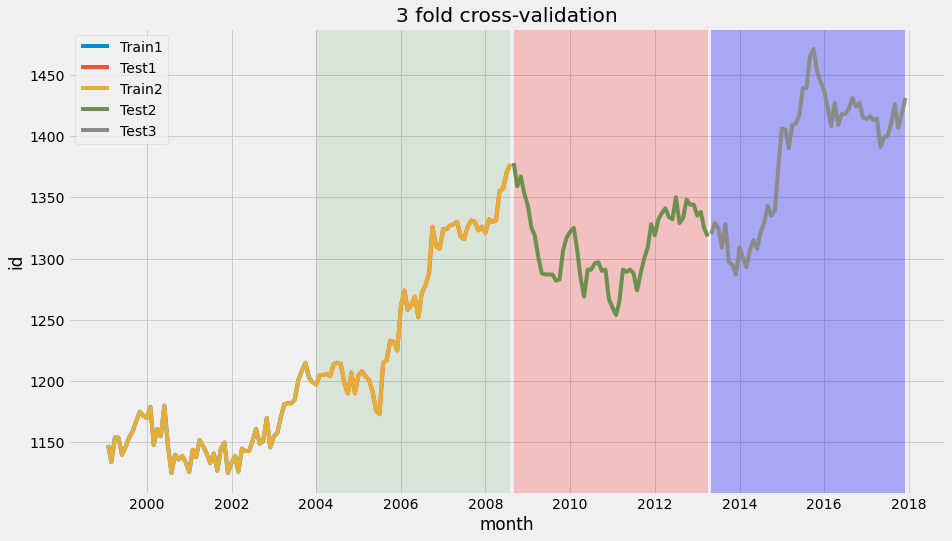

In [20]:
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
%matplotlib inline
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 14,8

#Labels and titles
plt.xlabel("month")
plt.ylabel("id")
plt.title("3 fold cross-validation")

#First fold- CV
plt.plot(train1.index, train1, label='Train1')
plt.plot(test1.index, test1, label='Test1')
#plt.plot(pred1.index, pred1, label='prediction1')
plt.legend(loc='best')
#Highlighting the region
plt.axvspan(test1.index[0], test1.index[-1],  facecolor='g', alpha=0.1)

#Second fold
plt.plot(train2.index, train2, label='Train2')
plt.plot(test2.index, test2, label='Test2')
#plt.plot(pred2.index, pred2, label='prediction2')
plt.legend(loc='best')
#Highlighting the region
plt.axvspan(test2.index[0], test2.index[-1],  facecolor='r', alpha=0.2)

#Third fold
plt.plot(test3.index, test3, label='Test3')
#plt.plot(pred3.index, pred3, label='prediction3')
plt.legend(loc='best')
#Highlighting the region
plt.axvspan(test3.index[0], test3.index[-1],  facecolor='b', alpha=0.3)